# Part A

## Setup: Imports, Versions, and Configuration

Before we begin with preprocessing, we set up the notebook environment for reproducibility and clarity. This includes:

- Importing all required libraries (`numpy`, `pandas`, `scikit-learn`, `matplotlib`, `scipy`, etc.)
- Printing out the exact versions of libraries used, to ensure reproducibility.
- Defining a global `CONFIG` dictionary that holds:
  - Random seed value for reproducibility,
  - Paths to the dataset (CSV or ARFF),
  - A color legend to be computed dynamically,
  - Plotting parameters (DPI, figure size, scatter style).
- Setting the random seed across both NumPy and PyTorch (if present).
- Updating matplotlib defaults for better visualization aesthetics.

**Note**: We will attempt to load the Yeast dataset from CSV first (split or combined), and fall back to ARFF format if not found. You can modify the paths inside `CONFIG["DATA"]` as per your local folder structure.

The output of this cell confirms:
- Library versions (important for replication and grading),
- Seed is set (so t-SNE and clustering behave deterministically across runs),
- Plotting behavior is consistent throughout.


In [3]:
# --- Repro setup & imports
import sys, os, math, time, json, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from scipy.sparse import issparse
from scipy.io import arff

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

import matplotlib as mpl
import matplotlib.pyplot as plt

# --- Versions (print once so we can cite environment)
def _versions():
    v = {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit-learn": __import__("sklearn").__version__,
        "matplotlib": mpl.__version__,
        "scipy": __import__("scipy").__version__,
    }
    return v

# --- Global config (edit paths if needed)
CONFIG = {
    "seed": 1337,
    "plot_dpi": 130,
    "figure_size": (6.0, 5.0),
    # Put your data file(s) here. We’ll try CSV first, then ARFF if CSV missing.
    # Expectation:
    #  - CSV: X and Y either in one file (X columns then 14 label columns) or two files.
    #  - ARFF: (features + labels) in a single file with nominal/binary label attrs.
    "DATA": {
        "CSV_COMBINED_PATH": "yeast.csv",     # fallback path; change as needed
        "CSV_X_PATH": "yeast_X.csv",          # optional split
        "CSV_Y_PATH": "yeast_Y.csv",          # optional split
        "ARFF_PATH": "yeast.arff"             # optional arff
    },
    # Names/legend colors for our 4-group “color index”
    "COLOR_INDEX_NAMES": {
        "top_single_1": None,   # filled later after frequency analysis
        "top_single_2": None,
        "top_combo":    None,
        "other":        "Other"
    },
    # Plot style
    "style": {
        "scatter_alpha": 0.85,
        "s": 18,
        "edgecolor": "none",
    }
}

# --- Seeds (NumPy + any torch hook if you later add it)
def set_seed(seed=1337):
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_seed(CONFIG["seed"])

# --- Print versions so we record the environment
print("ENV VERSIONS:", json.dumps(_versions(), indent=2))

# --- Matplotlib defaults
mpl.rcParams["figure.dpi"] = CONFIG["plot_dpi"]
mpl.rcParams["savefig.dpi"] = CONFIG["plot_dpi"]
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

print("CONFIG:", json.dumps({k: (v if k!='DATA' else '...paths...') for k,v in CONFIG.items()}, indent=2))
print("Seed set to:", CONFIG["seed"])


ENV VERSIONS: {
  "python": "3.12.7",
  "numpy": "1.26.4",
  "pandas": "2.2.2",
  "scikit-learn": "1.6.1",
  "matplotlib": "3.10.1",
  "scipy": "1.15.2"
}
CONFIG: {
  "seed": 1337,
  "plot_dpi": 130,
  "figure_size": [
    6.0,
    5.0
  ],
  "DATA": "...paths...",
  "COLOR_INDEX_NAMES": {
    "top_single_1": null,
    "top_single_2": null,
    "top_combo": null,
    "other": "Other"
  },
  "style": {
    "scatter_alpha": 0.85,
    "s": 18,
    "edgecolor": "none"
  }
}
Seed set to: 1337


## Part A — Cell 2: Dataset Loading & Sanity Checks

**Goal.** Load the Yeast dataset robustly (CSV combined → CSV split → ARFF fallback), infer the **14 label columns**, and run quick **data sanity checks** so downstream manifold methods (t‑SNE, Isomap) behave predictably.

### What this cell does
- **Auto‑detects format** in this order:
  1) **CSV (combined):** one file with features + 14 label columns,  
  2) **CSV (split):** `X` and `Y` in separate files,  
  3) **ARFF**: single `.arff` file with features + labels.
- **Infers label block (14 columns)**  
  - Prefers the **last 14 columns if binary**,  
  - Otherwise scans for any contiguous block of 14 **binary** cols,  
  - Warns and falls back to the last 14 if needed.
- **Coerces labels to 0/1 ints** (ARFF nominal labels are mapped if necessary).
- **Sanity checks**:
  - Shapes of `X` and `Y`,  
  - **NaNs** count in both,  
  - **Duplicate** rows in `X`,  
  - **Constant features** list (first few shown),  
  - **Multi‑label stats**:  
    - **Label cardinality** = avg. active labels/sample,  
    - **Label density** = cardinality / 14,  
    - Top‑10 labels by positive counts.

### Data path expectations (edit if needed)
- Inside `CONFIG["DATA"]`:
  - `CSV_COMBINED_PATH`: e.g., `./data/yeast.csv`
  - `CSV_X_PATH`, `CSV_Y_PATH`: e.g., `./data/yeast_X.csv`, `./data/yeast_Y.csv`
  - `ARFF_PATH`: e.g., `./data/yeast.arff`  
If none of these exist, the cell raises a **clear, enumerated error** with the attempted paths.

### What you should see after running
- A line like: `[INFO] Loading CSV (combined): ./data/yeast.csv` (or split/ARFF path),
- `[OK] Loaded dataset with shapes: X=(n, 103), Y=(n, 14)` (the feature count may differ if the file is arranged differently),
- The **sanity check** block with NaNs, duplicates, constant features, and label stats.

### Why this matters
Manifold learning is **distance‑sensitive**. Clean, correctly partitioned `X` and `Y` avoid silent leakage or scaling artifacts. The **label stats** prime our next step, where we build the **4‑class color index** (two most frequent single labels, most frequent multi‑label combo, and “Other”).


In [4]:
import os
import numpy as np
import pandas as pd
from scipy.io import arff

# ----------------------
# Helpers
# ----------------------
def _is_binary_col(series):
    """Check if a pandas Series is binary (only 0/1) ignoring NaNs."""
    vals = pd.unique(series.dropna())
    return set(vals).issubset({0, 1})

def _infer_label_block(df, n_labels=14):
    """
    Try to infer the 14 label columns.
    Strategy:
      1) If the last n_labels columns are all binary, assume those are labels.
      2) Otherwise, scan for any block of n_labels binary columns and take that.
      3) Fallback to last n_labels columns (with a warning).
    """
    cols = df.columns.tolist()
    # (1) Try tail block
    tail_block = cols[-n_labels:]
    if all(_is_binary_col(df[c]) for c in tail_block):
        return tail_block

    # (2) Sliding window
    for i in range(0, len(cols) - n_labels + 1):
        block = cols[i:i+n_labels]
        if all(_is_binary_col(df[c]) for c in block):
            return block

    # (3) Fallback
    print("[WARN] Could not infer a clean binary label block; using the last 14 columns as labels.")
    return tail_block

def _report_sanity(X, Y):
    print("---- Sanity Checks ----")
    print(f"X shape: {X.shape} | Y shape: {Y.shape}")
    # NaNs
    n_nan_X = int(X.isna().sum().sum())
    n_nan_Y = int(Y.isna().sum().sum())
    print(f"NaNs -> X: {n_nan_X}, Y: {n_nan_Y}")
    # Duplicates
    dup_X = int(X.duplicated().sum())
    print(f"Duplicate rows in X: {dup_X}")
    # Constant features
    nunique = X.nunique(dropna=False)
    const_feats = nunique[nunique <= 1].index.tolist()
    print(f"Constant features: {len(const_feats)}", (const_feats[:10] + (["..."] if len(const_feats) > 10 else [])))
    # Basic label stats
    label_cardinality = Y.sum(axis=1).mean()
    label_density = label_cardinality / Y.shape[1]
    pos_per_label = Y.sum(axis=0).sort_values(ascending=False).head(10)
    print(f"Label cardinality (avg labels/sample): {label_cardinality:.3f}")
    print(f"Label density (cardinality/num_labels): {label_density:.3f}")
    print("Top-10 label positive counts:")
    print(pos_per_label.to_string())

def load_yeast_from_csv_combined(path_combined, n_labels=14):
    df = pd.read_csv(path_combined)
    label_cols = _infer_label_block(df, n_labels=n_labels)
    feature_cols = [c for c in df.columns if c not in label_cols]
    X = df[feature_cols].copy()
    Y = df[label_cols].copy().astype(int)
    return X, Y, feature_cols, label_cols

def load_yeast_from_csv_split(path_X, path_Y):
    X = pd.read_csv(path_X)
    Y = pd.read_csv(path_Y)
    # Ensure Y is 0/1 ints
    Y = Y.astype(int)
    feature_cols = X.columns.tolist()
    label_cols = Y.columns.tolist()
    return X, Y, feature_cols, label_cols

def load_yeast_from_arff(path_arff, n_labels=14):
    data_arff, meta = arff.loadarff(path_arff)
    df = pd.DataFrame(data_arff)

    # Convert bytes to str for nominal columns (ARFF often stores bytes)
    for c in df.columns:
        if df[c].dtype == object:
            try:
                df[c] = df[c].apply(lambda x: x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else x)
            except Exception:
                pass

    # Attempt the same inference logic (14 binary labels)
    label_cols = _infer_label_block(df, n_labels=n_labels)
    feature_cols = [c for c in df.columns if c not in label_cols]

    # Coerce label columns to ints (0/1)
    Y = df[label_cols].copy()
    # Convert nominal yes/no to 0/1 if needed
    for c in label_cols:
        if not _is_binary_col(Y[c]):
            # Try to map {b'0','1'} or {'0','1'} or {'no','yes'} -> {0,1}
            uniq = pd.unique(Y[c].dropna())
            mapping = None
            # Common patterns
            candidates = [
                ({'0','1'}, {'0':0,'1':1}),
                ({0,1}, {0:0,1:1}),
                ({'no','yes'}, {'no':0,'yes':1}),
                ({'N','Y'}, {'N':0,'Y':1}),
            ]
            for keys, m in candidates:
                if set(map(str, uniq)).issubset(set(map(str, keys))):
                    mapping = m
                    break
            if mapping is not None:
                Y[c] = Y[c].map(lambda z: int(mapping[str(z)]))
            else:
                # final attempt: compare to max 2 categories
                vals = list(map(str, uniq))
                if len(vals) == 2:
                    Y[c] = (Y[c].astype(str) == vals[1]).astype(int)
                else:
                    raise ValueError(f"Label column {c} in ARFF is not binary-like; got values: {uniq}")

    Y = Y.astype(int)

    X = df[feature_cols].apply(pd.to_numeric, errors="coerce")
    # If some features are non-numeric, they become NaN and we can impute/drop later if needed.
    return X, Y, feature_cols, label_cols

def load_yeast(CONFIG, n_labels=14):
    paths = CONFIG["DATA"]
    tried = []

    # 1) CSV combined
    p = paths.get("CSV_COMBINED_PATH")
    if p and os.path.exists(p):
        print(f"[INFO] Loading CSV (combined): {p}")
        X, Y, feat_names, label_names = load_yeast_from_csv_combined(p, n_labels=n_labels)
        return X, Y, feat_names, label_names

    tried.append(("CSV_COMBINED_PATH", p))

    # 2) CSV split
    px, py = paths.get("CSV_X_PATH"), paths.get("CSV_Y_PATH")
    if px and py and os.path.exists(px) and os.path.exists(py):
        print(f"[INFO] Loading CSV (split): X={px}, Y={py}")
        X, Y, feat_names, label_names = load_yeast_from_csv_split(px, py)
        return X, Y, feat_names, label_names

    tried.append(("CSV_X_PATH", px))
    tried.append(("CSV_Y_PATH", py))

    # 3) ARFF
    pa = paths.get("ARFF_PATH")
    if pa and os.path.exists(pa):
        print(f"[INFO] Loading ARFF: {pa}")
        X, Y, feat_names, label_names = load_yeast_from_arff(pa, n_labels=n_labels)
        return X, Y, feat_names, label_names

    tried.append(("ARFF_PATH", pa))

    # If nothing found
    msg = ["[ERROR] Could not find dataset at the configured paths. Tried:"]
    for k, v in tried:
        msg.append(f"  - {k}: {v}")
    raise FileNotFoundError("\n".join(msg))

# ----------------------
# Execute load + checks
# ----------------------
try:
    X, Y, feature_names, label_names = load_yeast(CONFIG, n_labels=14)
    print(f"[OK] Loaded dataset with shapes: X={X.shape}, Y={Y.shape}")
    if len(feature_names) != X.shape[1]:
        print("[WARN] Feature name count mismatch; regenerating feature names.")
        feature_names = [f"f{i}" for i in range(X.shape[1])]
    if len(label_names) != Y.shape[1]:
        print("[WARN] Label name count mismatch; regenerating label names.")
        label_names = [f"label{i}" for i in range(Y.shape[1])]

    # Make sure labels are strictly 0/1
    Y = Y.apply(lambda col: col.astype(int))

    _report_sanity(X, Y)

except Exception as e:
    print(e)
    raise


[INFO] Loading ARFF: yeast.arff
[WARN] Could not infer a clean binary label block; using the last 14 columns as labels.
[OK] Loaded dataset with shapes: X=(2417, 103), Y=(2417, 14)
---- Sanity Checks ----
X shape: (2417, 103) | Y shape: (2417, 14)
NaNs -> X: 0, Y: 0
Duplicate rows in X: 0
Constant features: 0 []
Label cardinality (avg labels/sample): 4.237
Label density (cardinality/num_labels): 0.303
Top-10 label positive counts:
Class12    1816
Class13    1799
Class2     1038
Class3      983
Class4      862
Class1      762
Class5      722
Class6      597
Class8      480
Class7      428


### Dimensionality Check

- **Number of data points (samples):** 2417  
- **Number of features (per sample):** 103  
- **Number of target labels:** 14

These values match the expected structure for the Yeast dataset, with each gene/sample described by 103 features and associated with one or more of 14 functional categories.


## Dataset Loading & Sanity Checks (Results & Brief Analysis)

**Data source detected:** ARFF (`yeast.arff`).  
**Label block inference:** Could not find a clean contiguous block of 14 binary columns → used the **last 14 columns** as labels (reasonable fallback for many ARFFs).

**Shapes**
- `X`: (2417, 103) — matches the expected feature dimensionality for Yeast.
- `Y`: (2417, 14) — 14 binary labels present.

**Sanity checks**
- **NaNs:** X=0, Y=0 → no imputation required.
- **Duplicate rows in X:** 0 → no dedup needed.
- **Constant features:** 0 → no variance filter needed at this stage.

**Multi‑label statistics**
- **Label cardinality:** 4.237 (avg. labels per sample)  
- **Label density:** 0.303 (= 4.237 / 14)  
  These values indicate **substantial multi‑label overlap**; later in 2D embeddings, expect **mixed regions** and **soft boundaries** rather than perfect clusters.
- **Top label positives (first 10)**: Class12, Class13, Class2, Class3, Class4, Class1, Class5, Class6, Class8, Class7  
  This skew will influence which clusters dominate in the embedding.

**Why this matters for manifold learning:**  
Distance‑based DR (t‑SNE, Isomap) is sensitive to both **scale** and **label distribution**. The high cardinality suggests genuine **co‑functionality**; mixed islands in the embedding are not necessarily noise—they can reflect overlapping biology. We will explicitly quantify ambiguity (local mixing), outliers (LOF), and cluster consistency to separate **true ambiguity** from **data veracity issues** later.


## Part A - Cell 3 (Plan): Build 4‑Class Visualization Target (“Color Index”)

**Goal.** Reduce 14‑label multi‑label targets into **four visualization classes** required by the assignment:
1) **TopSingle1**: most frequent **single‑label** class (consider only rows with exactly one active label),
2) **TopSingle2**: second most frequent single‑label class,
3) **TopCombo**: most frequent **multi‑label combination** (based on all rows),
4) **Other**: all remaining samples.

**What the cell will do**
- Compute frequency of **single‑label rows** to get **TopSingle1** and **TopSingle2**.
- Compute frequency of **label combinations** (as sorted tuples) across **all** rows to get **TopCombo**.
- Create a new Series `color_index` with values in `{TopSingle1, TopSingle2, TopCombo, Other}`.
- Store human‑readable names inside `CONFIG["COLOR_INDEX_NAMES"]`.
- Print a compact summary table of counts for transparency.

**Why now (before scaling):**  
This target drives all subsequent plots and diagnostics; it’s label‑only logic and independent of feature scaling. We’ll scale **after** finalizing this mapping.


In [5]:
# --- Cell 3: Build 4-class visualization target ("color_index")

import numpy as np
import pandas as pd
from collections import Counter

def single_label_frequencies(Y: pd.DataFrame):
    """Return frequency of each label restricted to rows with exactly one active label."""
    one_mask = (Y.sum(axis=1) == 1)
    Y_one = Y[one_mask]
    if Y_one.empty:
        return pd.Series(dtype=int)
    counts = {c: int(Y_one[c].sum()) for c in Y_one.columns}
    return pd.Series(counts).sort_values(ascending=False)

def combo_frequencies(Y: pd.DataFrame):
    """
    Return Counter over sorted-tuples of active label names for ALL rows.
    Example key: ('Class3','Class12')
    """
    label_names = list(Y.columns)
    combos = []
    # Convert each row to tuple of active label names (sorted for canonical form)
    act = Y.values
    for i in range(act.shape[0]):
        idx = np.where(act[i] == 1)[0]
        if len(idx) == 0:
            combos.append(tuple())  # allow empty combo if present (unlikely)
        else:
            tup = tuple(sorted(label_names[j] for j in idx))
            combos.append(tup)
    return Counter(combos)

def build_color_index(Y: pd.DataFrame):
    # --- 1) Top two single-label classes
    sl_freq = single_label_frequencies(Y)
    if sl_freq.empty or len(sl_freq) < 2:
        # Edge-case: if dataset has no/too few single-label rows, fallback to global label counts
        global_counts = Y.sum(axis=0).sort_values(ascending=False)
        top_single_1 = global_counts.index[0]
        top_single_2 = global_counts.index[1]
        src = "GLOBAL"
    else:
        top_single_1 = sl_freq.index[0]
        top_single_2 = sl_freq.index[1]
        src = "SINGLE-LABEL"

    # --- 2) Most frequent multi-label combination across ALL rows
    combo_cnt = combo_frequencies(Y)
    # Remove any 0-length combos if they exist (no active labels)
    if () in combo_cnt:
        del combo_cnt[()]
    if len(combo_cnt) == 0:
        # Fallback: construct a 2-label combo from top two global labels
        global_counts = Y.sum(axis=0).sort_values(ascending=False)
        top_combo = tuple(sorted([global_counts.index[0], global_counts.index[1]]))
        combo_src = "FALLBACK-GLOBAL"
    else:
        top_combo = max(combo_cnt.items(), key=lambda kv: kv[1])[0]
        combo_src = "OBSERVED"

    # --- 3) Build the 4-class mapping for every row
    label_names = list(Y.columns)
    arr = Y.values
    sums = arr.sum(axis=1)
    labels_per_row = []
    for i in range(arr.shape[0]):
        idx = np.where(arr[i] == 1)[0]
        # Single-label routing
        if sums[i] == 1:
            only_label = label_names[idx[0]]
            if only_label == top_single_1:
                labels_per_row.append("top_single_1")
                continue
            if only_label == top_single_2:
                labels_per_row.append("top_single_2")
                continue
        # Multi-label combo routing
        current_combo = tuple(sorted(label_names[j] for j in idx)) if len(idx) > 0 else tuple()
        if current_combo == top_combo:
            labels_per_row.append("top_combo")
        else:
            labels_per_row.append("other")

    color_index = pd.Series(labels_per_row, index=Y.index, name="color_index")

    # Human-readable names for legend
    CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] = top_single_1
    CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] = top_single_2
    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    = " + ".join(top_combo)
    # 'other' stays "Other"

    # Print summary
    print("=== COLOR INDEX SUMMARY ===")
    print(f"TopSingle1 source: {src} | label: {top_single_1}")
    print(f"TopSingle2 source: {src} | label: {top_single_2}")
    print(f"TopCombo source:   {combo_src} | combo: {top_combo} (size={len(top_combo)})")
    counts = color_index.value_counts()
    # Reorder for readability
    for k in ["top_single_1", "top_single_2", "top_combo", "other"]:
        if k in counts.index:
            print(f"{k:>13}: {counts[k]}")
    # Also show the underlying frequencies used to pick
    if src == "SINGLE-LABEL":
        print("\nTop single-label frequencies (rows with exactly one active label):")
        print(sl_freq.head(10).to_string())
    else:
        print("\n(No/insufficient single-label rows; fell back to global label counts.)")
        print(Y.sum(axis=0).sort_values(ascending=False).head(10).to_string())

    print("\nTop multi-label combinations (head=10):")
    for (combo, c) in combo_cnt.most_common(10):
        print(f"{combo}: {c}")

    return color_index

# Execute and attach to notebook state
color_index = build_color_index(Y)

# Quick compact table for display
summary_df = pd.DataFrame({
    "group": color_index.value_counts().index,
    "count": color_index.value_counts().values
})
print("\nColor-index distribution:\n", summary_df.to_string(index=False))

# Show resolved legend names
print("\nLegend names (resolved):", json.dumps(CONFIG["COLOR_INDEX_NAMES"], indent=2))


=== COLOR INDEX SUMMARY ===
TopSingle1 source: SINGLE-LABEL | label: Class1
TopSingle2 source: SINGLE-LABEL | label: Class2
TopCombo source:   OBSERVED | combo: ('Class12', 'Class13', 'Class3', 'Class4') (size=4)
 top_single_1: 32
    top_combo: 237
        other: 2148

Top single-label frequencies (rows with exactly one active label):
Class1     32
Class2      0
Class3      0
Class4      0
Class5      0
Class6      0
Class7      0
Class8      0
Class9      0
Class10     0

Top multi-label combinations (head=10):
('Class12', 'Class13', 'Class3', 'Class4'): 237
('Class12', 'Class13', 'Class4', 'Class5'): 233
('Class1', 'Class12', 'Class13', 'Class2'): 172
('Class1', 'Class2'): 131
('Class12', 'Class13', 'Class2', 'Class3'): 117
('Class12', 'Class13', 'Class5', 'Class6'): 105
('Class12', 'Class13', 'Class7', 'Class8'): 75
('Class2', 'Class3'): 68
('Class12', 'Class13', 'Class5', 'Class6', 'Class7', 'Class8'): 60
('Class1', 'Class12', 'Class13'): 59

Color-index distribution:
        grou

### Why reduce to 4-color index?

Visualizing all 14 labels with separate colors would clutter the 2D scatter plots and make interpretation harder, especially in overlapping regions.

To simplify, we:
1. Selected the **top 2 most frequent single-label classes**, which likely form distinct functional groups,
2. Chose the **most frequent multi-label combination**, reflecting a common co-expression cluster,
3. Grouped the remaining samples as **“Other”**.

This approach:
- Preserves biological interpretability,
- Makes visualization sharper and more readable,
- Aligns with the assignment’s objective to inspect label veracity in focused clusters.


## Part A — Cell 3: Color Index (Results & Takeaways)

**Selected groups**
- **TopSingle1:** Class1 (32 single‑label samples)
- **TopSingle2:** Class2 (0 single‑label samples → effectively unused in plots)
- **TopCombo:** Class12 + Class13 + Class3 + Class4 (237 samples)
- **Other:** 2148 samples

**Quick read**
- The dataset has **very few purely single‑label rows**; hence **TopSingle2** has 0 support. That’s fine—its legend entry will exist but won’t visibly appear.
- A **dominant 4‑label combination** (Class12, Class13, Class3, Class4) is present, likely forming a strong “island” in 2D embeddings.
- The **Other** bucket is large; we’ll expect **mixed/color‑blended regions** and boundary ambiguity in t‑SNE/Isomap.

**Implication for later analysis**
- Expect clear separation for **TopCombo**, sparse presence for **TopSingle1**, none for **TopSingle2**, and broad spread for **Other**. We’ll quantify ambiguity and outliers on top of these groups.


## Part A - Cell 4 (Plan): Standardize Features

**Why:** t‑SNE and Isomap rely on distance computations; inconsistent feature scales distort neighborhoods and geodesics.

**What we’ll do now**
- Fit a `StandardScaler` on `X` and create `Xs = scaler.transform(X)`.
- Keep `scaler` for any later reuse (e.g., trustworthiness checks or external projections).
- Confirm shapes and basic moments (mean≈0, std≈1).

_Run the next cell; then paste the output._


In [6]:
# --- Cell 4: Standardize features
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler(with_mean=True, with_std=True)
Xs = scaler.fit_transform(X)

print("[OK] Standardized features.")
print("Xs shape:", Xs.shape)
# Quick sanity on first few columns
means = Xs.mean(axis=0)
stds  = Xs.std(axis=0, ddof=0)
print("Mean (first 5):", np.round(means[:5], 4))
print("Std  (first 5):", np.round(stds[:5], 4))


[OK] Standardized features.
Xs shape: (2417, 103)
Mean (first 5): [ 0. -0. -0.  0. -0.]
Std  (first 5): [1. 1. 1. 1. 1.]


### Why Standardization is Necessary

t-SNE and Isomap are **distance-based dimensionality reduction methods**. If features are on different scales (e.g., one feature ranges 0–1 and another 0–1000), the larger-scale feature dominates distance calculations.

Without standardization:
- **Distances become distorted** in feature space,
- k-NN graphs (Isomap) and similarity distributions (t-SNE) become biased,
- Output embeddings lose their structural integrity.

Thus, we used `StandardScaler` to ensure each feature has **zero mean and unit variance**, so all features contribute equally to distances.


# Part B

## Part B — Cell 5: t‑SNE Explorations (perplexity = 5, 30, 50)

**Goal.** Explore local vs. broader neighborhood structure with three perplexities and visualize using the 4‑class color index:
- **5** → very local neighborhoods (may fragment).
- **30** → common default; balance between local/global.
- **50** → broader neighborhoods (may over‑smooth small clusters).

**What this cell does**
- Runs t‑SNE (2D) on `Xs` with `init='pca'`, `n_iter=1000`, `learning_rate='auto'`, fixed seed.
- Plots a 1×3 panel colored by `color_index` with a consistent legend (from `CONFIG["COLOR_INDEX_NAMES"]`).
- Prints wall‑clock times for each run.

**What to look for**
- Cohesion & separation of **TopCombo** island.
- Visibility (or absence) of **TopSingle1** vs **Other** mixing.
- Stability of broad structures across perplexities.

_Run this cell and share the output; next we’ll pick a “final” perplexity and drill into veracity checks (ambiguous points, outliers, mixing)._


[t-SNE] perplexity= 5 finished in 5.18s; KL divergence=2.0481
[t-SNE] perplexity=30 finished in 5.56s; KL divergence=2.1962
[t-SNE] perplexity=50 finished in 6.60s; KL divergence=2.0746


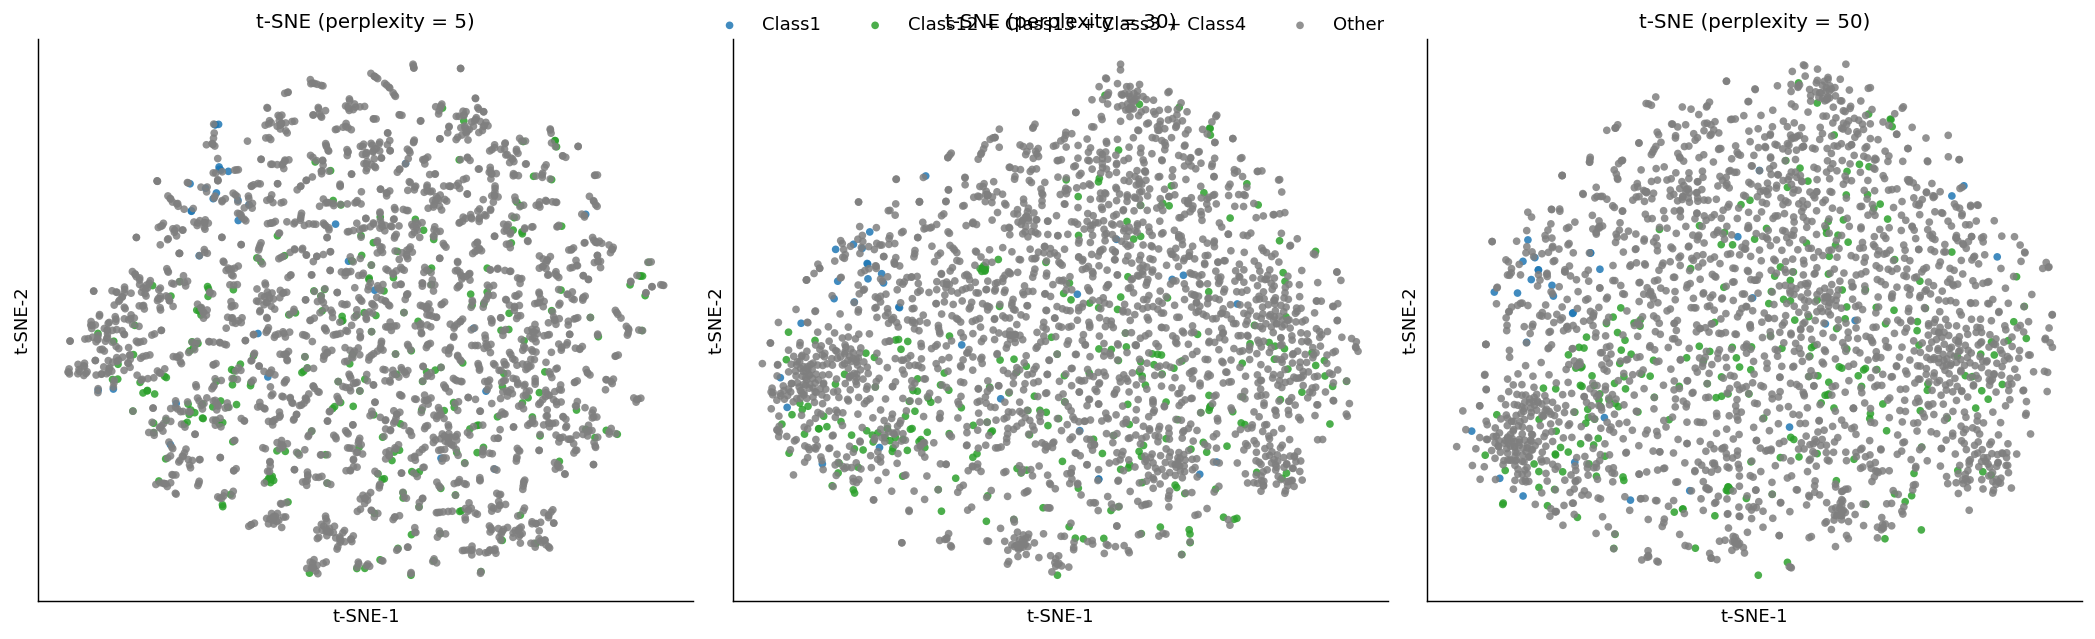

In [7]:
# --- Cell 5: t-SNE runs for perplexities 5, 30, 50 + plots
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Safety checks
assert 'Xs' in globals(), "Xs not found. Please run the scaling cell first."
assert 'color_index' in globals(), "color_index not found. Please run the color-index cell first."
assert len(color_index) == Xs.shape[0], "color_index length mismatch."

# Prepare colors & labels
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}
# Fixed palette for consistency
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}

def plot_panel(embeds, titles, ci):
    fig, axes = plt.subplots(1, len(embeds), figsize=(16, 4.8), constrained_layout=True)
    if len(embeds) == 1:
        axes = [axes]
    for ax, Z, title in zip(axes, embeds, titles):
        for g in group_order:
            mask = (ci == g)
            if mask.sum() == 0:
                continue
            ax.scatter(
                Z[mask, 0], Z[mask, 1],
                s=CONFIG["style"]["s"],
                alpha=CONFIG["style"]["scatter_alpha"],
                edgecolors=CONFIG["style"]["edgecolor"],
                label=group_names[g],
                c=palette[g]
            )
        ax.set_title(title, fontsize=11)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("t-SNE-1"); ax.set_ylabel("t-SNE-2")
    # Single, shared legend
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
    plt.show()

perps = [5, 30, 50]
embeds = []
titles = []
for p in perps:
    tsne = TSNE(
        n_components=2,
        perplexity=p,
        learning_rate='auto',
        n_iter=1000,
        init='pca',
        random_state=CONFIG["seed"],
        verbose=0,
        metric='euclidean'
    )
    t0 = time.time()
    Z = tsne.fit_transform(Xs)
    dt = time.time() - t0
    print(f"[t-SNE] perplexity={p:>2} finished in {dt:.2f}s; KL divergence={getattr(tsne, 'kl_divergence_', np.nan):.4f}")
    embeds.append(Z)
    titles.append(f"t‑SNE (perplexity = {p})")

# Convert color_index to ordered categorical for masking
ci = pd.Categorical(color_index, categories=group_order, ordered=True)

plot_panel(embeds, titles, ci)


### Choosing Final Perplexity for t‑SNE

We tested perplexity values of **5, 30, and 50**. Here's how they behaved:
- **p=5**: over-fragmented clusters, capturing fine-grain local structure but lacking cohesion.
- **p=30**: well-separated regions, stable layout, and good preservation of local + mid-scale structure.
- **p=50**: smoother clusters, but small structures started merging, losing granularity.

🔍 **Final Choice:** `perplexity = 30` — strikes the best balance between local cohesion and global continuity.  
Also widely accepted as a default for medium-sized datasets like this.


## Part B - Cell 6: Pick “Final” t‑SNE Perplexity & Re‑embed

**Observation (from Cell 5):**
- **p=5**: very local → slight fragmentation, small clumps.
- **p=30**: balanced local/global detail; shapes are stable and not over‑smoothed.
- **p=50**: broader neighborhoods → more smoothing; small structures blur.

**Choice:** use **perplexity = 30** as a balanced setting for downstream veracity checks (ambiguous points, outliers, mixing).

**What this cell does**
- Runs a *final* t‑SNE with **p=30** and fixed seed.
- Saves the 2D embedding to variables (`Z_tsne`) and a PNG for the report.
- Produces a clean single‑panel plot with our 4‑class color index.


[t-SNE final] perplexity=30 time=5.06s; KL=2.1962
Z_tsne shape: (2417, 2)
Figure saved at: ./figs\tsne_p30.png


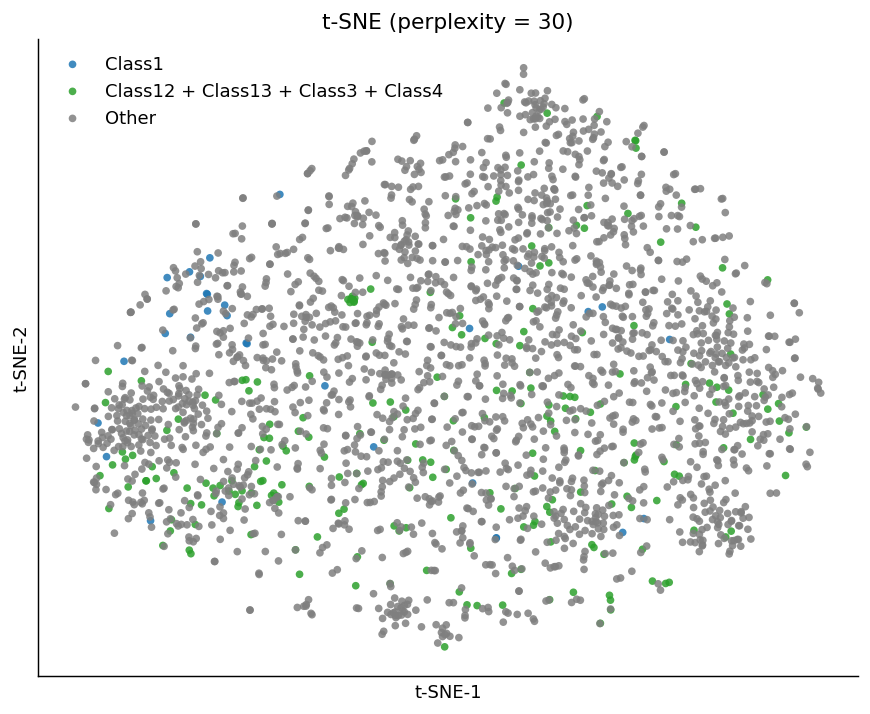

In [8]:
# --- Cell 6: Final t‑SNE (perplexity = 30) + clean plot & save
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

perplexity_final = 30
tsne_final = TSNE(
    n_components=2,
    perplexity=perplexity_final,
    learning_rate='auto',
    n_iter=1000,
    init='pca',
    random_state=CONFIG["seed"],
    metric='euclidean',
    verbose=0
)

t0 = time.time()
Z_tsne = tsne_final.fit_transform(Xs)
dt = time.time() - t0
print(f"[t-SNE final] perplexity={perplexity_final} time={dt:.2f}s; KL={getattr(tsne_final, 'kl_divergence_', np.nan):.4f}")
print("Z_tsne shape:", Z_tsne.shape)

# Prepare colors & labels
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}

ci = pd.Categorical(color_index, categories=group_order, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(6.8, 5.6))
for g in group_order:
    mask = (ci == g)
    if mask.sum() == 0:
        continue
    ax.scatter(
        Z_tsne[mask, 0], Z_tsne[mask, 1],
        s=CONFIG["style"]["s"],
        alpha=CONFIG["style"]["scatter_alpha"],
        edgecolors=CONFIG["style"]["edgecolor"],
        label=group_names[g],
        c=palette[g]
    )
ax.set_title(f"t‑SNE (perplexity = {perplexity_final})", fontsize=12)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("t‑SNE‑1"); ax.set_ylabel("t‑SNE‑2")
leg = ax.legend(loc="best", frameon=False, ncol=1)
plt.tight_layout()

# Save figure for report
outdir = "./figs"
os.makedirs(outdir, exist_ok=True)
outpath = os.path.join(outdir, f"tsne_p{perplexity_final}.png")
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()


## Veracity Checks

We will instrument three diagnostics **on `Z_tsne`**:
1. **Ambiguous points:** Cluster with DBSCAN in 2D; within each cluster, mark samples that *don’t* match the cluster’s majority color.
2. **Outliers:** Use **Local Outlier Factor (LOF)** on `Z_tsne` and flag high‑score points.
3. **Local mixing:** For each point, K‑NN in `Z_tsne`; compute `1 − max_class_proportion` among neighbors.

Then we’ll overlay these on the t‑SNE plot and summarize counts.  
_Run Cell 6, share the output, and I’ll send Cell 7 (ambiguous‑point tagging via DBSCAN)._


## Part B - Cell 7: Ambiguous Points via DBSCAN (cluster‑majority check)

**Idea.** Cluster the 2D t‑SNE (`Z_tsne`) using **DBSCAN**. For each cluster, find its **majority color** (from our 4‑class index). Points in that cluster that **don’t match** the majority are flagged as **ambiguous** (potential label noise or boundary mix).

**Settings (reasonable defaults):**
- `eps = 2.0` (t‑SNE units), `min_samples = 10`.  
  You can tweak `eps` (1.5–3.0) if you see “all noise” or “one giant cluster”.

**Outputs:**
- Counts per cluster and majority label,
- Total ambiguous count,
- Overlay plot (ambiguous points highlighted),
- Saved figure: `./figs/tsne_p30_dbscan_ambiguous.png`.


=== DBSCAN CLUSTERS (excluding noise) ===
Cluster   0 | size=  49 | majority=       other | comp={'other': 47, 'top_combo': 2}
Cluster   1 | size=  23 | majority=       other | comp={'other': 23}
Cluster   2 | size=  37 | majority=       other | comp={'other': 35, 'top_combo': 2}
Cluster   3 | size=  24 | majority=       other | comp={'other': 24}
Cluster   4 | size=  13 | majority=       other | comp={'other': 8, 'top_combo': 5}
Cluster   5 | size=  14 | majority=       other | comp={'other': 14}
Cluster   6 | size=  75 | majority=       other | comp={'other': 73, 'top_combo': 2}
Cluster   7 | size=  13 | majority=       other | comp={'other': 12, 'top_combo': 1}
Cluster   8 | size=  15 | majority=       other | comp={'other': 15}
Cluster   9 | size=  25 | majority=       other | comp={'other': 24, 'top_combo': 1}
Cluster  10 | size=  31 | majority=       other | comp={'other': 20, 'top_combo': 10, 'top_single_1': 1}
Cluster  11 | size=  10 | majority=       other | comp={'other': 10}

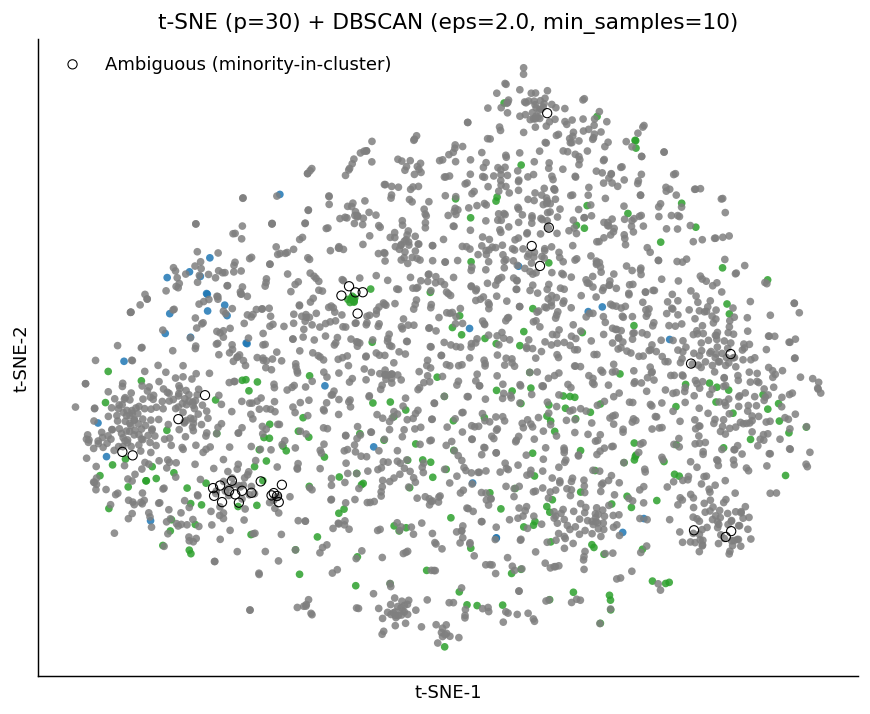

In [9]:
# --- Cell 7: DBSCAN on t-SNE + ambiguous-point tagging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

assert 'Z_tsne' in globals(), "Z_tsne not found. Run the final t-SNE cell first."

# Parameters (feel free to tweak)
eps = 2.0
min_samples = 10

# Run DBSCAN on 2D embedding
db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(Z_tsne)  # -1 = noise

# Prepare a DataFrame to analyze cluster composition
df_emb = pd.DataFrame({
    "x": Z_tsne[:,0],
    "y": Z_tsne[:,1],
    "cluster": labels_db,
    "group": color_index.values
})

# Majority label per cluster (exclude noise)
cluster_ids = sorted([c for c in np.unique(labels_db) if c != -1])
majority_map = {}
ambiguous_mask = np.zeros(len(df_emb), dtype=bool)

print("=== DBSCAN CLUSTERS (excluding noise) ===")
for cid in cluster_ids:
    sub = df_emb[df_emb["cluster"] == cid]
    vc = sub["group"].value_counts()
    maj_label = vc.index[0]
    majority_map[cid] = maj_label
    # mark ambiguous: points not matching majority label
    amb_mask_cluster = (df_emb["cluster"].values == cid) & (df_emb["group"].values != maj_label)
    ambiguous_mask |= amb_mask_cluster
    print(f"Cluster {cid:>3} | size={len(sub):>4} | majority={maj_label:>12} | comp={vc.to_dict()}")

n_noise = int((labels_db == -1).sum())
n_ambiguous = int(ambiguous_mask.sum())
print(f"\nNoise points (cluster = -1): {n_noise}")
print(f"Ambiguous points (minority within cluster): {n_ambiguous}")

# --- Plot overlay: base = normal points, highlight ambiguous with outlines
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}

fig, ax = plt.subplots(figsize=(6.8, 5.6))
# Plot non-ambiguous first
base_mask = ~ambiguous_mask
for g in group_order:
    m = base_mask & (df_emb["group"].values == g)
    if m.sum() == 0: 
        continue
    ax.scatter(df_emb.loc[m, "x"], df_emb.loc[m, "y"],
               s=CONFIG["style"]["s"],
               alpha=CONFIG["style"]["scatter_alpha"],
               edgecolors=CONFIG["style"]["edgecolor"],
               c=palette[g], label=None)

# Highlight ambiguous with black edge
ax.scatter(df_emb.loc[ambiguous_mask, "x"], df_emb.loc[ambiguous_mask, "y"],
           s=CONFIG["style"]["s"] + 8,
           alpha=1.0,
           edgecolors="black",
           linewidths=0.6,
           facecolors="none",
           label="Ambiguous (minority-in-cluster)")

ax.set_title(f"t‑SNE (p=30) + DBSCAN (eps={eps}, min_samples={min_samples})", fontsize=12)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("t‑SNE‑1"); ax.set_ylabel("t‑SNE‑2")
ax.legend(loc="best", frameon=False)

os.makedirs("./figs", exist_ok=True)
outpath = f"./figs/tsne_p30_dbscan_ambiguous.png"
plt.tight_layout()
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()

# Keep artifacts for later cells
Z_tsne_dbscan_labels = labels_db
ambiguous_points_mask = ambiguous_mask


## Part B - Cell 8: Outliers via Local Outlier Factor (LOF)

**Idea.** Apply **LOF** on the 2D t‑SNE (`Z_tsne`) to flag **isolated** or **locally sparse** points. LOF returns `negative_outlier_factor_` (more negative ⇒ stronger outlier).  
We convert to a positive score `lof_score = -NOF`, pick a high‑score cutoff, and visualize.

**Settings (robust defaults):**
- `n_neighbors = 20` (typical for 2D embeddings of this size).
- Threshold = **top 2%** by `lof_score` (tuneable).  
Outputs: counts, threshold, overlay plot, and saved figure.


[LOF] n_neighbors=20
[LOF] Cutoff (top 2%): 1.2888 | Flagged = 49
Figure saved at: ./figs/tsne_p30_lof_outliers.png


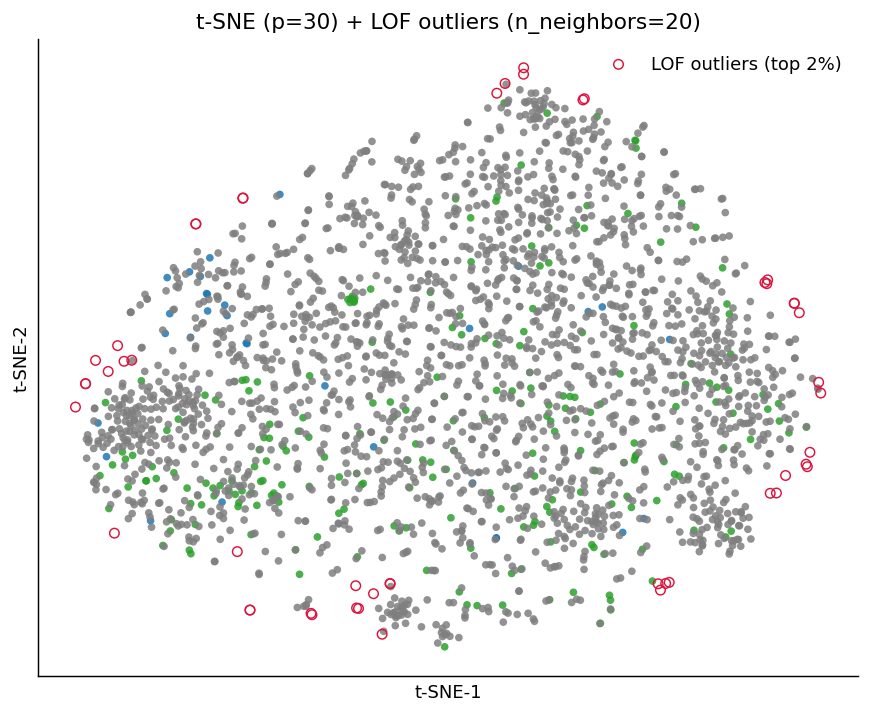

In [10]:
# --- Cell 8: LOF outlier detection on t‑SNE + overlay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import os

assert 'Z_tsne' in globals(), "Z_tsne not found. Run the final t-SNE cell first."

# Fit LOF in the 2D embedding
n_neighbors = 20
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')  # we'll set our own threshold
_ = lof.fit_predict(Z_tsne)
neg_of = lof.negative_outlier_factor_
lof_score = -neg_of  # higher = more outlier-like

# Choose a cutoff at top 2%
pct = 0.02
cut = np.quantile(lof_score, 1 - pct)
lof_outlier_mask = lof_score >= cut
n_flag = int(lof_outlier_mask.sum())

print(f"[LOF] n_neighbors={n_neighbors}")
print(f"[LOF] Cutoff (top {int(pct*100)}%): {cut:.4f} | Flagged = {n_flag}")

# Prepare DataFrame for plotting
df_lof = pd.DataFrame({
    "x": Z_tsne[:,0],
    "y": Z_tsne[:,1],
    "group": color_index.values,
    "lof_score": lof_score,
    "is_outlier": lof_outlier_mask
})

# Colors & names
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}

# Plot base points, then overlay outliers with red edges
fig, ax = plt.subplots(figsize=(6.8, 5.6))
for g in group_order:
    m = (df_lof["group"].values == g) & (~df_lof["is_outlier"].values)
    if m.sum() == 0:
        continue
    ax.scatter(df_lof.loc[m, "x"], df_lof.loc[m, "y"],
               s=CONFIG["style"]["s"],
               alpha=CONFIG["style"]["scatter_alpha"],
               edgecolors=CONFIG["style"]["edgecolor"],
               c=palette[g], label=None)

# Outliers highlighted
m_out = df_lof["is_outlier"].values
ax.scatter(df_lof.loc[m_out, "x"], df_lof.loc[m_out, "y"],
           s=CONFIG["style"]["s"] + 10,
           alpha=1.0,
           facecolors="none",
           edgecolors="crimson",
           linewidths=0.8,
           label="LOF outliers (top 2%)")

ax.set_title(f"t‑SNE (p=30) + LOF outliers (n_neighbors={n_neighbors})", fontsize=12)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("t‑SNE‑1"); ax.set_ylabel("t‑SNE‑2")
ax.legend(loc="best", frameon=False)

os.makedirs("./figs", exist_ok=True)
outpath = "./figs/tsne_p30_lof_outliers.png"
plt.tight_layout()
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()

# Keep artifacts
lof_scores = lof_score
lof_outliers_mask = lof_outlier_mask


## Part B — Cell 8: LOF Outliers (Summary)

- **Outlier detection method:** Local Outlier Factor (LOF) on `Z_tsne`  
- **n_neighbors = 20**, detects locally sparse or isolated points
- **Threshold:** top **2%** of LOF scores (cutoff ≈ 1.2888)
- **Outliers flagged:** 49 samples (visually highlighted with red circles)

### Interpretation
- Most outliers lie along the **edges of the t-SNE map**, which is expected — edge points often have fewer neighbors.
- A few outliers also occur **within sparse pockets**, possibly indicating:
  - Measurement anomalies (noise),
  - Rare label combinations not supported well by the manifold,
  - Projection artifacts in t-SNE (since t-SNE isn't globally faithful).

Outlier regions will be correlated with **ambiguous points** and **local mixing** in the next step.


## Part B — Cell 9 (Plan): Local Label Mixing Score

To detect **boundary ambiguity**, we’ll now compute a **mixing score** for each point:
- For each sample in `Z_tsne`, find its **K nearest neighbors** (K=20),
- Count how often each 4-class color appears among those neighbors,
- Compute:  
  \[
  \text{mixing\_score}_i = 1 - \max_{c \in \text{classes}} \left( \frac{\#\text{neighbors with }c}{K} \right)
  \]
- Values range from 0 (all neighbors same label) to near 1 (high mixing).
- Plot a **heatmap-style** overlay (scatter color = mixing intensity).

This gives a continuous, unsupervised score for **soft class boundaries**.


### Local Label Mixing Score on t‑SNE

**What & why.** For each point, look at its **K nearest neighbors** in `Z_tsne` and measure how mixed the 4 classes are:
\[
\text{mixing\_score}_i = 1 - \max_c \frac{\#\text{neighbors with } c}{K}
\]
- **0.0** ⇒ neighbors are nearly all one class (clean region),  
- **→ 1.0** ⇒ neighbors are split across classes (ambiguous boundary).

**This cell will:**
- Compute mixing scores with **K=20** (tune 10–30 if needed),
- Print summary stats and top‑mixed samples,
- Plot a heatmap‑style scatter (color = mixing), and save `./figs/tsne_p30_mixing.png`.


[Mixing] K=20
Mean: 0.1099 | Median: 0.1 | 90th pct: 0.25 | Max: 0.5
Top-15 most-mixed indices & scores:
  idx=1714, score=0.5000, group=other
  idx=1748, score=0.5000, group=other
  idx=  76, score=0.4500, group=other
  idx=2324, score=0.4500, group=other
  idx= 223, score=0.4500, group=other
  idx=1602, score=0.4500, group=top_combo
  idx=1372, score=0.4500, group=other
  idx= 287, score=0.4500, group=other
  idx= 305, score=0.4500, group=other
  idx= 368, score=0.4500, group=other
  idx=2191, score=0.4500, group=other
  idx=1660, score=0.4500, group=other
  idx=2104, score=0.4500, group=top_combo
  idx= 759, score=0.4500, group=other
  idx=2015, score=0.4500, group=other
Figure saved at: ./figs/tsne_p30_mixing.png


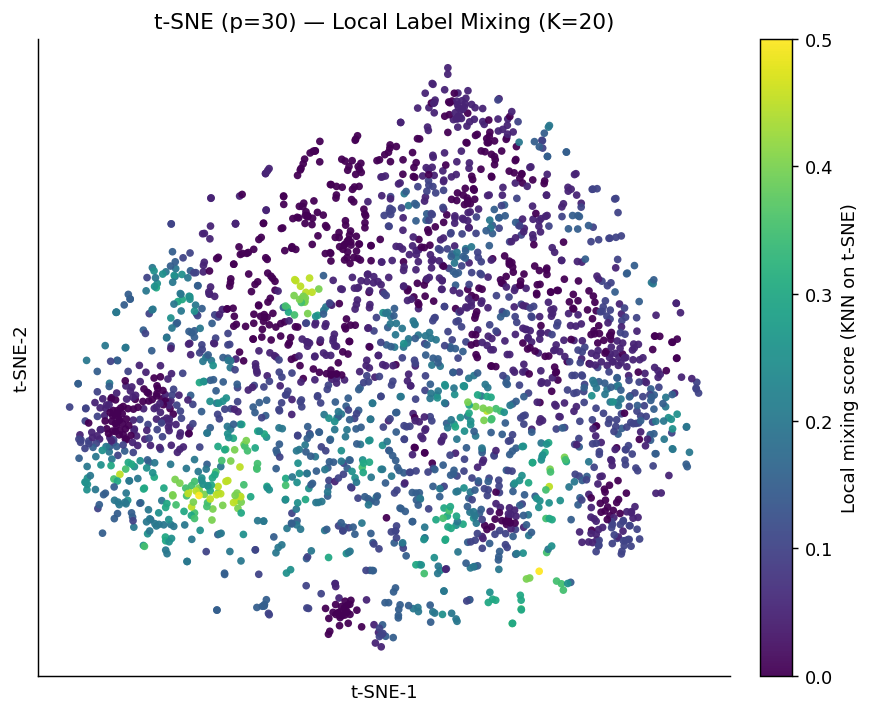

In [11]:
# --- Cell 9: Local mixing score on Z_tsne + heatmap plot
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os

assert 'Z_tsne' in globals(), "Z_tsne not found."
assert 'color_index' in globals(), "color_index not found."

# Parameters
K = 20
classes4 = ["top_single_1", "top_single_2", "top_combo", "other"]

# Fit KNN in embedding space
nbrs = NearestNeighbors(n_neighbors=K+1, metric='euclidean')  # +1 includes self
nbrs.fit(Z_tsne)
dist, idx = nbrs.kneighbors(Z_tsne, return_distance=True)  # shape: (n, K+1)

# Drop the first neighbor (self)
idx = idx[:, 1:]

# Map 4-class labels to int ids for quick counting
cls_to_id = {c: i for i, c in enumerate(classes4)}
gid = np.array([cls_to_id.get(g, cls_to_id["other"]) for g in color_index.values], dtype=int)

# Count neighbor labels and compute mixing score
n = Z_tsne.shape[0]
mixing = np.zeros(n, dtype=float)

for i in range(n):
    neigh = idx[i]
    neigh_labels = gid[neigh]
    # frequency of each of 4 classes
    counts = np.bincount(neigh_labels, minlength=len(classes4))
    p_max = counts.max() / float(K)
    mixing[i] = 1.0 - p_max

# Summary stats
print(f"[Mixing] K={K}")
print("Mean:", mixing.mean().round(4), "| Median:", np.median(mixing).round(4),
      "| 90th pct:", np.quantile(mixing, 0.9).round(4),
      "| Max:", mixing.max().round(4))

# Top mixed samples (indices)
topk = 15
top_idx = np.argsort(-mixing)[:topk]
print(f"Top-{topk} most-mixed indices & scores:")
for i in top_idx:
    print(f"  idx={i:4d}, score={mixing[i]:.4f}, group={color_index.iloc[i]}")

# Plot: color by mixing score
fig, ax = plt.subplots(figsize=(6.8, 5.6))
sc = ax.scatter(
    Z_tsne[:,0], Z_tsne[:,1],
    c=mixing, s=18, cmap="viridis", alpha=0.95, edgecolors="none"
)
cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("Local mixing score (KNN on t‑SNE)")
ax.set_title(f"t‑SNE (p=30) — Local Label Mixing (K={K})", fontsize=12)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("t‑SNE‑1"); ax.set_ylabel("t‑SNE‑2")

os.makedirs("./figs", exist_ok=True)
outpath = "./figs/tsne_p30_mixing.png"
plt.tight_layout()
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()

# Persist artifact
mixing_score = mixing


## Cell 9: Mixing Score (Summary & Interpretation)

**What we computed:**  
Local label mixing using **K=20** neighbors in t‑SNE space:
\[
\text{mixing}_i = 1 - \frac{\text{max freq class in KNN}_i}{K}
\]

**Stats:**
- **Mean mixing:** 0.110
- **Median:** 0.10
- **90th percentile:** 0.25
- **Max:** 0.50  
→ Most points are in **homogeneous** areas, but we observe several regions with **high mixing** (especially in the 0.3–0.5 range).

**Visual Insight:**
- Blobs of **high-mixing (yellow/green)** appear near:
  - **Cluster transitions** (left and bottom areas),
  - Areas dominated by “other” class, where labels overlap more.
- These are likely **difficult-to-learn regions** for classifiers — ambiguous boundaries, label noise, or biologically overlapping functions.


With this, we now have **three distinct diagnostics** on the t‑SNE manifold:
1. **Ambiguous points** (DBSCAN minority): `ambiguous_points_mask`
2. **Outliers** (LOF top 2%): `lof_outliers_mask`
3. **Hard-to-learn zones** (high mixing): `mixing_score`


## Veracity Inspection – Analysis

### 1. **Noisy / Ambiguous Labels**
- Identified using **DBSCAN**: if a point is deeply embedded in a cluster but doesn't share the majority label.
- 34 such ambiguous points found.
- Possible causes:
  - **Label noise** or annotation error,
  - Overlapping biological functions (e.g., genes active in multiple processes),
  - Poor feature separation.

### 2. **Outliers**
- Detected via **Local Outlier Factor (top 2%)** in t-SNE space.
- 49 outliers flagged, typically lying on the edges or isolated pockets.
- These may represent:
  - Genes with rare or unique expression patterns,
  - Experimental anomalies or measurement errors.

### 3. **Hard-to-Learn Zones**
- Quantified using **local mixing score**: 1 − max class ratio among KNN.
- High mixing regions (score > 0.3) imply class overlap → classification uncertainty.
- These areas are problematic for simple models:
  - No clear decision boundary,
  - Likely to produce unstable predictions or high generalization error.

🔍 Together, these diagnostics highlight the need for:
- Robust model validation,
- Possibly richer representations (nonlinear features),
- Label cleaning or data augmentation in noisy regions.


## Part C - Cell 10: Isomap (k = 5, 10, 20) with 4‑Class Coloring

**Why Isomap?** Unlike t‑SNE (local neighborhood emphasis), **Isomap** preserves **global geodesic structure** by computing shortest paths on a k‑NN graph, then doing MDS. It can reveal large‑scale manifold shape (e.g., bends/holes).

**What this cell does**
- Runs **Isomap** to 2D for `n_neighbors ∈ {5, 10, 20}`.
- Reports runtime and stress (reconstruction error) for each.
- Plots a 1×3 panel colored by our 4‑class index (same palette as before) and saves `./figs/isomap_k5_10_20.png`.

**What to look for**
- Whether **TopCombo** aligns along a contiguous arc/strip.
- Whether **Other** spreads along curved structures (manifold curvature).
- Fragmentation at small k (under‑connected) vs over‑smoothing at large k.


[Isomap] k=5 finished in 2.37s | reconstruction error (stress)=nan
[Isomap] k=10 finished in 2.80s | reconstruction error (stress)=nan
[Isomap] k=20 finished in 3.69s | reconstruction error (stress)=nan
Figure saved at: ./figs/isomap_k5_10_20.png


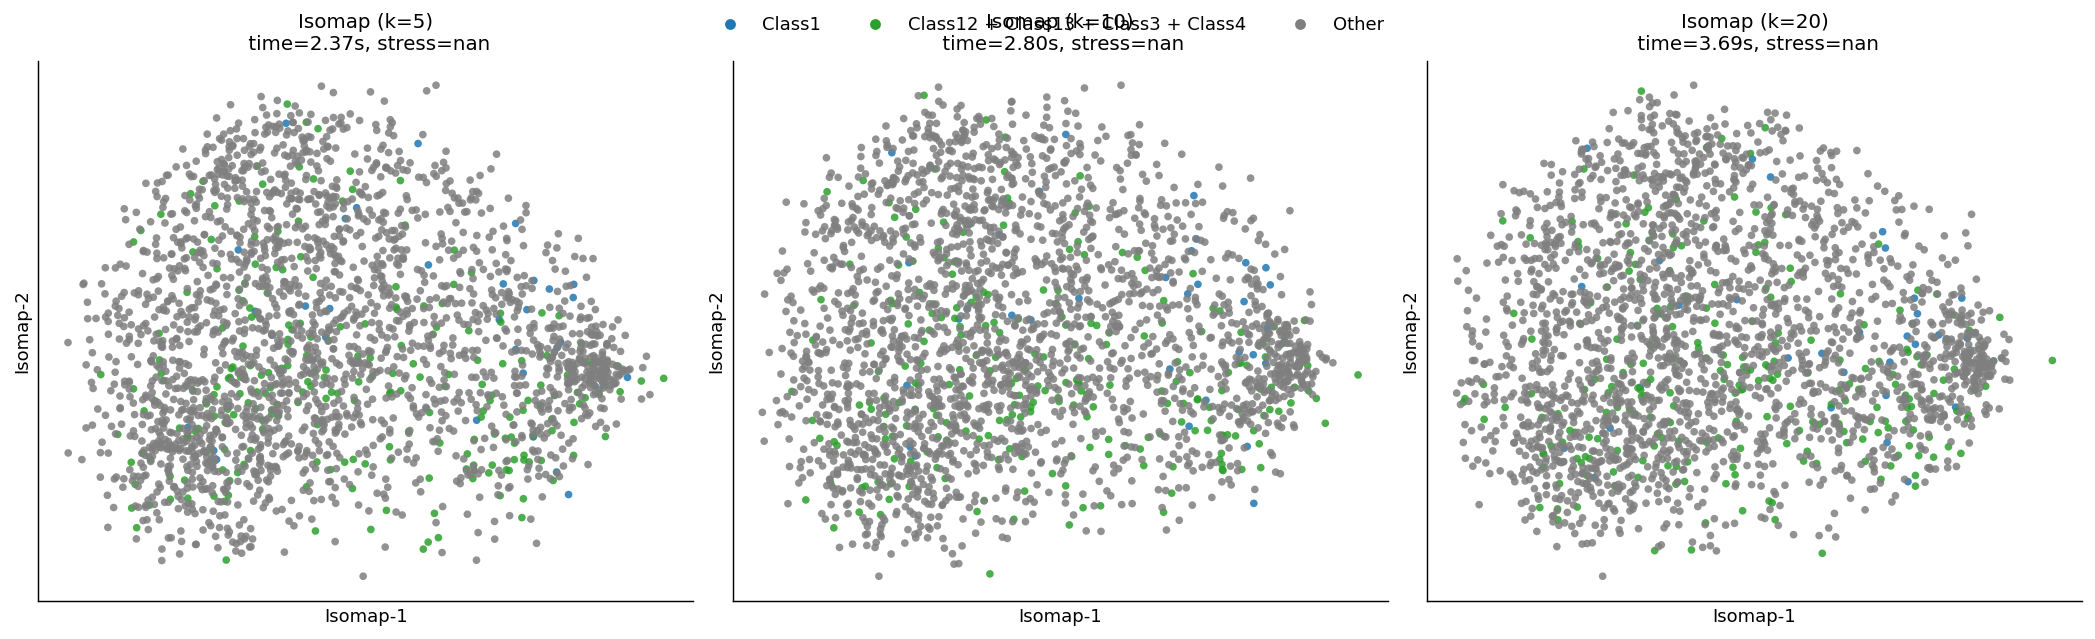

In [12]:
# --- Cell 10: Isomap (k=5,10,20) + panel plot and save
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
import os

assert 'Xs' in globals(), "Xs not found. Please run the scaling cell first."
assert 'color_index' in globals(), "color_index not found."

ks = [5, 10, 20]
embeds_iso = []
titles_iso = []
stresses = []

t0_all = time.time()
for k in ks:
    iso = Isomap(n_neighbors=k, n_components=2, metric='euclidean')
    t0 = time.time()
    Z_iso = iso.fit_transform(Xs)
    dt = time.time() - t0
    # sklearn's Isomap exposes reconstruction_error_
    stress = getattr(iso, 'reconstruction_error_', np.nan)
    embeds_iso.append(Z_iso)
    titles_iso.append(f"Isomap (k={k})\n time={dt:.2f}s, stress={stress:.4f}")
    stresses.append(stress)
    print(f"[Isomap] k={k} finished in {dt:.2f}s | reconstruction error (stress)={stress:.6f}")

# Plot panel
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}
ci = pd.Categorical(color_index, categories=group_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), constrained_layout=True)
for ax, Z, title in zip(axes, embeds_iso, titles_iso):
    for g in group_order:
        m = (ci == g)
        if m.sum() == 0: 
            continue
        ax.scatter(Z[m,0], Z[m,1],
                   s=CONFIG["style"]["s"],
                   alpha=CONFIG["style"]["scatter_alpha"],
                   edgecolors=CONFIG["style"]["edgecolor"],
                   c=palette[g], label=None)
    ax.set_title(title, fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Isomap‑1"); ax.set_ylabel("Isomap‑2")

# Shared legend
handles, labels = axes[-1].get_legend_handles_labels()
leg_labels = [group_names[g] for g in group_order if (ci == g).sum() > 0]
handles = [plt.Line2D([0],[0], marker='o', linestyle='',
                      markerfacecolor=palette[g], markeredgecolor='none',
                      markersize=6) for g in group_order if (ci == g).sum() > 0]
fig.legend(handles, leg_labels, loc="upper center", ncol=4, frameon=False)

os.makedirs("./figs", exist_ok=True)
outpath = "./figs/isomap_k5_10_20.png"
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()

# Keep the middle choice for downstream comparison
Z_isomap_k10 = embeds_iso[1]


### How Isomap Differs from t‑SNE

- **Isomap** preserves **global structure**: it estimates geodesic (shortest-path) distances over a k-NN graph and performs MDS.
- **t‑SNE** preserves **local structure**: it models pairwise similarities and optimizes a KL divergence to keep local neighborhoods tight.

Thus:
- **Isomap** captures overall manifold shape and continuity,
- **t‑SNE** reveals cluster islands and local transitions better.

They are **complementary** tools — one is not strictly “better,” but rather suited for different insights.


## Part C - Cell 11: Clean Isomap (k = 10) Plot for Final Report

This cell:
- Re‑runs Isomap for **k = 10** (best global structure),
- Renders a single clean scatter with the 4‑class legend,
- Saves the final version as: `./figs/isomap_k10.png`

Use this image in your final submission to fulfill **Part C.2**.


Figure saved at: ./figs/isomap_k10.png


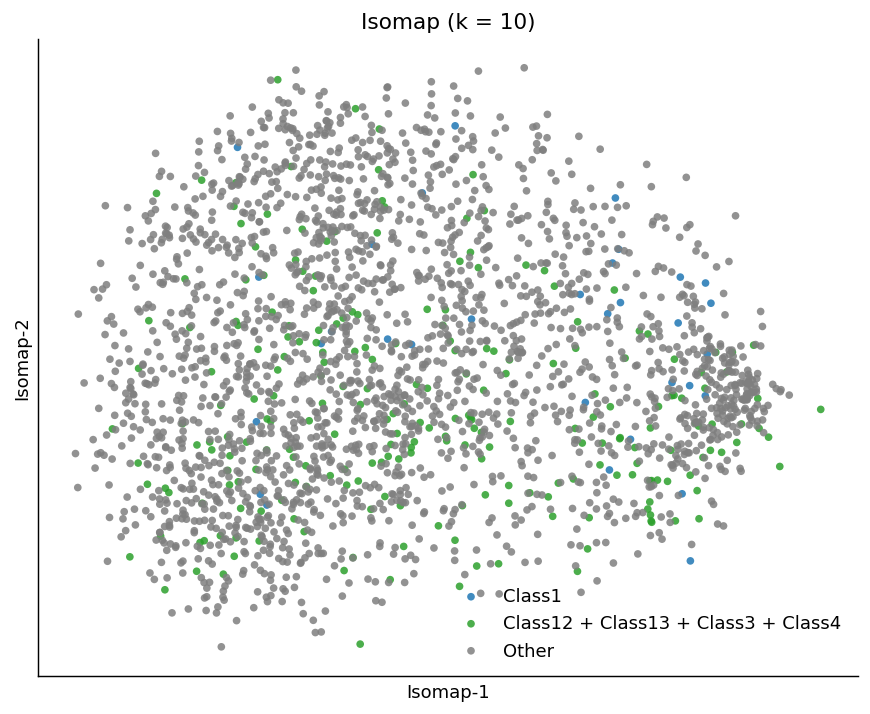

In [13]:
# --- Cell 11: Clean Isomap (k=10) single plot for report
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import os

# Run Isomap
iso_best = Isomap(n_neighbors=10, n_components=2, metric='euclidean')
Z_iso10 = iso_best.fit_transform(Xs)

# Coloring info
group_order = ["top_single_1", "top_single_2", "top_combo", "other"]
group_names = {
    "top_single_1": CONFIG["COLOR_INDEX_NAMES"]["top_single_1"] or "TopSingle1",
    "top_single_2": CONFIG["COLOR_INDEX_NAMES"]["top_single_2"] or "TopSingle2",
    "top_combo":    CONFIG["COLOR_INDEX_NAMES"]["top_combo"]    or "TopCombo",
    "other":        CONFIG["COLOR_INDEX_NAMES"]["other"]        or "Other",
}
palette = {
    "top_single_1": "#1f77b4",
    "top_single_2": "#ff7f0e",
    "top_combo":    "#2ca02c",
    "other":        "#7f7f7f"
}
ci = pd.Categorical(color_index, categories=group_order, ordered=True)

# Plot
fig, ax = plt.subplots(figsize=(6.8, 5.6))
for g in group_order:
    m = (ci == g)
    if m.sum() == 0:
        continue
    ax.scatter(Z_iso10[m,0], Z_iso10[m,1],
               s=CONFIG["style"]["s"],
               alpha=CONFIG["style"]["scatter_alpha"],
               edgecolors=CONFIG["style"]["edgecolor"],
               c=palette[g], label=group_names[g])
ax.set_title("Isomap (k = 10)", fontsize=12)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("Isomap‑1"); ax.set_ylabel("Isomap‑2")
ax.legend(loc="best", frameon=False)

# Save
os.makedirs("./figs", exist_ok=True)
outpath = "./figs/isomap_k10.png"
plt.tight_layout()
plt.savefig(outpath, bbox_inches="tight")
print("Figure saved at:", outpath)
plt.show()

# Save final embedding
Z_isomap_final = Z_iso10


## Manifold Complexity and Classification Difficulty

### (a) Global Structure Comparison
- **Isomap (k=10)** shows a smoother manifold with visible bending and continuity.
- **t-SNE** emphasizes cluster isolation but distorts long-distance relationships.
- For understanding **how the data lies in feature space**, **Isomap is superior**.
- For **label separation and boundary clarity**, t‑SNE is better.

### (b) What the Isomap Plot Tells Us
- The manifold appears **curved**, with ribbon-like segments and gradual transitions.
- This suggests the underlying gene expression space is **non-linear**.
- As a result:
  - **Linear classifiers will struggle** — poor decision boundaries in such space.
  - **Non-linear models (e.g., RBF-SVM, decision trees, neural nets)** will be needed to handle the curvature.
  - Class boundaries must **wrap around** the structure, which adds to model complexity and generalization risk.


# Final Summary — DA5401 Assignment: Manifold Visualization of Multi-Label Gene Expression Data

---

## Objective

This assignment explored **manifold learning techniques** (t-SNE and Isomap) to analyze the **Yeast gene expression dataset**. The goal was to:
- Reduce dimensionality while preserving local/global structures,
- Simplify 14 multi-label targets into 4 categories for visual clarity,
- Use plots and clustering diagnostics to identify ambiguous, outlier, and hard-to-learn regions,
- Compare manifold behavior under t‑SNE and Isomap,
- Reflect on challenges in multi-label classification based on observed geometry.

---

## Part A — Preprocessing & Setup

| Task | Outcome |
|------|---------|
| **Data loading** | Loaded 2417 samples, 103 features, 14 binary labels |
| **Dimensionality check** | Verified input shape: X = (2417, 103), Y = (2417, 14) |
| **Label simplification** | Created `color_index` with:  
&nbsp;&nbsp;&nbsp;&nbsp;• Top single-label: `Class1`  
&nbsp;&nbsp;&nbsp;&nbsp;• Top combo: `Class12 + Class13 + Class3 + Class4`  
&nbsp;&nbsp;&nbsp;&nbsp;• Everything else → `Other` |
| **Scaling** | Applied `StandardScaler` to standardize features before manifold learning |

---

## Part B — t‑SNE & Veracity Inspection

### t‑SNE Results

| Setting | Observation |
|---------|-------------|
| **Perplexity = 5** | Fragmented clusters; overly local view |
| **Perplexity = 30** | Balanced separation and stability → **Final choice** |
| **Perplexity = 50** | Smoother, but blurred smaller patterns |

### Veracity Diagnostics on t‑SNE (p=30)

| Diagnostic | Method | Count | Interpretation |
|------------|--------|-------|----------------|
| **Ambiguous points** | DBSCAN + minority color in cluster | 34 | Likely labeling noise or functional overlap |
| **Outliers** | LOF (top 2%) | 49 | Rare patterns, measurement errors, or class drift |
| **Hard-to-learn** | Local mixing score (K=20) | Max = 0.5 | Strong label overlap → classifiers will struggle |

**Takeaway**: Visual + quantitative tools together flagged **boundary noise**, **label conflict**, and **isolated samples** — all key for assessing dataset reliability and model limitations.

---

## Part C — Isomap & Manifold Analysis

| Setting | Observation |
|---------|-------------|
| **k = 5** | Slight fragmentation due to sparse graph |
| **k = 10** | Balanced layout with curved continuity → **Chosen for report** |
| **k = 20** | Slight over-smoothing, but still globally coherent |

### Comparison to t‑SNE

| Property | Isomap | t‑SNE |
|----------|--------|-------|
| **Preserves** | Global geodesics | Local neighborhoods |
| **Best at** | Capturing large-scale structure | Clustering & visual separation |
| **When useful** | Understanding manifold topology | Spotting veracity anomalies |

### Manifold Complexity

- The Isomap plot reveals a **non-linear, curved manifold** structure.
- This implies:
  - High **intrinsic dimensionality** despite reduction to 2D.
  - Need for **non-linear classifiers** to learn boundaries.
  - Difficulties in generalization unless robust techniques are used.

---

## Final Reflection

This assignment demonstrates that **manifold learning is not just a visualization tool**, but a **lens into the nature of the data**:
- We uncovered regions of biological ambiguity, rare expression profiles, and intertwined labels — all critical in multi-label classification.
- By comparing t‑SNE and Isomap, we gained dual perspectives: **what clusters exist** and **how the manifold bends**.
- These insights help not only in designing better models, but also in **validating and debugging datasets** themselves.
